# Detekce Phishingové webové stránky

**Phishing** je podvodná technika používaná na internetu, která slouží k získání citlivých údajů, které se dají zpeněžit (čísla kreditních karet, přihlašovací údaje do internetového bankovnictví, nebo session ids v prohlížeči, které mohou být použity pro CSRF útok). Odkaz na podvodnou stránku je obvykle zaslán emailem nebo v rámci instant messagingu, kde se komunikace vydává za nějaký důvěryhodný zdroj (sociální síť, internetové bankovnictví, platební portál, orgán veřejné správy atd.). Oklamaný adresát poté na této stránce může útočníkům požadované citlivé údaje poskytnout.

Na [Kagglu](https://www.kaggle.com/kunal4892/phishingandlegitimateurls) je k dispozici dataset, který obsahuje charakteristiky url adres spolu s označením, zda se jedná o phishingovou stránku.

## Sloupce v původním datasetu

|Název sloupce|Popis|
|:---|:---|
|**domain**|url adresa stránky|
|**ranking**|Page Ranking|
|**isIp**|příznak, zda se jedná o IP adresu|
|**valid**|validní adresa podle Google Whois API|
|**activeDuration**|Další metrika z Google Whois API, udává, jak dlouho je adresa v chodu (zdroj neudává ani odkaz na API ani jednotky)|
|**urlLen**|délka celé url adresy v počtu znaků|
|**is@**|příznak, jestli URL adresa obsahuje znak '**@**'|
|**isredirect**|příznak, který udává, jestli jsou v URL adrese dvě popředné lomítka ('**//**'), ty totiž slouží k redirectu na adresu, která po nich následuje|
|**haveDash**|příznak, který udává, jestli je v doméně nebo v subdoméně znak '**-**'|
|**domainLen**|délka domény v počtu znaků (počítají se top level doména, subdomény i tečky)|
|**nosOfSubdomain**|počet subdomén|
|**label**|cílová proměnná, **0** znamená neškodnou stránku, **1** znamená phishingovou stránku|

Cílem této seminární práce je použít tento dataset k vytvoření a evaluaci modelů, které by sloužili ke klasifikaci url adresy jako bezpečné nebo jako potencionálně podvodné. Jedná se tedy o binární klasifikační úlohu. Součástí práce je explorativní analýza dat, jejich předzpracování, odvození nových hodnot a tvorba modelů pomocí různých algoritmů a jejich evaluace.

# Import knihoven a dat

Data jsou načtena z URL adresy **Github** repozitáře (dostupného na [této](https://github.com/PetrNovak96/ph_web_cl)) adrese, aby nebylo použití notebooku závislé na lokální dostupnosti csv souborů. Soubory jsou dva:

Soubor **tinyURLs.csv** obsahuje seznam různých tiny url služeb. 

Soubor **dataset.csv** obsahuje původní dataset dostupný z **Kagglu**, do kterého je předpočítán sloupec **usesHttps**. Zjištění, zda stránky umožňují HTTPS připojení je při tomto rozsahu dat náročná **I / 0** operace. Pro výpočet tohoto sloupce byl použit skript [**https_threading.py**](https://github.com/PetrNovak96/ph_web_cl/blob/master/https_threading.py), který tuto operaci rozložil na 100 vláken. Výpočet potom trval zhruba hodinu.

### < Poznamky oponenta >
- Nadpis import knihoven ale o knihovnach jsem se nic nedozvedel
- Custom script pro vypocet sloupce usesHttps

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import math
import requests
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

dataset_url = 'https://raw.githubusercontent.com/PetrNovak96/ph_web_cl/master/dataset.csv'
tinyurls_url = 'https://raw.githubusercontent.com/PetrNovak96/ph_web_cl/master/tinyURLs.csv'

df = pd.read_csv(dataset_url)
tinyurls = pd.read_csv(tinyurls_url)

### < Poznamky oponenta >
- Skript obsahuje balík, který není součástí distribuce anaconda a v repozitáři neni přítomný requirements.txt ani pipfile.lock pro vytvoření kopie env.

![package](img/imblearn_error.png)

In [2]:
# KOD OPONENTA
# Slo by vyresit inline 
!pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.6.2-py3-none-any.whl (163 kB)
  Using cached numpy-1.18.4-cp37-cp37m-win_amd64.whl (12.8 MB)
  Using cached joblib-0.14.1-py2.py3-none-any.whl (294 kB)
  Using cached scikit_learn-0.22.2.post1-cp37-cp37m-win_amd64.whl (6.5 MB)
  Using cached scipy-1.4.1-cp37-cp37m-win_amd64.whl (30.9 MB)


# Explorace dat


Prozkoumání hodnot ranking pro tento dataset vytvořilo dva sloupce na opačných koncích osy s vetšinovým zastoupením hodnot.

### < Poznamky oponenta >
- Chyby mi prehledne shrnuti datasetu, pocet radku, interval v jakem se pohybuje.
- Nektere sloupce nerespektuji projektove konvence
    - isredirect - neni camel case
    - valid - neobsahuje sloveso na zacatku znacici ze se jedna o boolean type
    - is@ - nema to byt spis have@

In [5]:
# KOD OPONENTA
df.describe()

,ranking,isIp,valid,activeDuration,urlLen,is@,isredirect,haveDash,domainLen,nosOfSubdomain,label,usesHttps
count,9.591000e+04,95910.000000,95910.000000,95910.000000,95910.000000,95910.000000,95910.000000,95910.000000,95910.000000,95910.000000,95910.000000,95910.000000
mean,6.118618e+06,0.000229,0.573892,3747.876144,69.327442,0.002773,0.007444,0.157856,23.409061,2.387718,0.582984,0.228172
std,4.835254e+06,0.015144,0.494512,3974.587188,69.740134,0.052591,0.085960,0.364608,25.426852,2.140997,0.493068,0.419656
min,1.000000e+00,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
25%,3.205600e+04,0.000000,0.000000,0.000000,31.000000,0.000000,0.000000,0.000000,14.000000,2.000000,0.000000,0.000000
50%,1.000000e+07,0.000000,1.000000,2192.000000,44.000000,0.000000,0.000000,0.000000,17.000000,2.000000,1.000000,0.000000
75%,1.000000e+07,0.000000,1.000000,7670.000000,78.000000,0.000000,0.000000,0.000000,22.000000,2.000000,1.000000,0.000000
max,1.000000e+07,1.000000,1.000000,15707.000000,2175.000000,1.000000,1.000000,1.000000,244.000000,34.000000,1.000000,1.000000


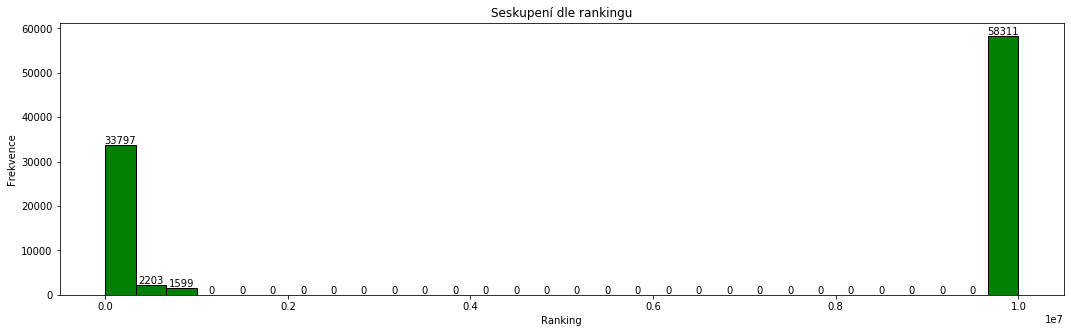

In [6]:
plot8 = df.ranking.plot(kind='hist', bins = 30, figsize=(18,5), facecolor = 'green', edgecolor='black')
plot8.set_title('Seskupení dle rankingu')
plot8.set_ylabel('Frekvence')
plot8.set_xlabel('Ranking')
def add_value_labels(plot8, spacing=5):
    for rect in plot8.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -5
            va = 'top'
        label = "{:.0f}".format(y_value)
        plot8.annotate(label,(x_value, y_value), xytext=(0, -1),textcoords="offset points", ha='center',va=va)
add_value_labels(plot8)

### < Poznamky oponenta >
- z horniho grafu to bez kontextu vypada, ze je ranking boolean. Dalsi graf, ale odhaluje ze je to obor prirozenych cisel.

Pro další průzkum jsem vzal pouze ranking, který není 0 a který není ani maximální.

### < Poznamky oponenta >
- presto dalsi grafy obsahuji vsechny pozorovani

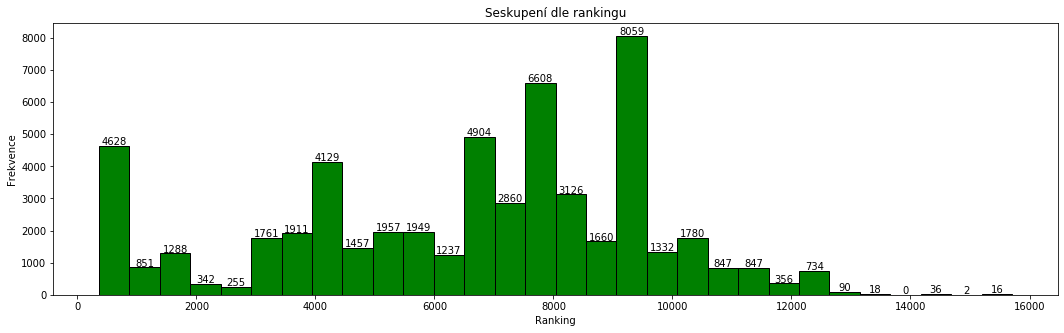

In [7]:
values2 = df.activeDuration
values2 = values2[values2.between(1,999999)]

plot9 = values2.plot(kind='hist', bins = 30, figsize=(18,5), facecolor = 'green', edgecolor='black')
plot9.set_title('Seskupení dle rankingu')
plot9.set_ylabel('Frekvence')
plot9.set_xlabel('Ranking')
def add_value_labels(plot9, spacing=5):
    for rect in plot9.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -5
            va = 'top'
        label = "{:.0f}".format(y_value)
        plot9.annotate(label,(x_value, y_value), xytext=(0, -1),textcoords="offset points", ha='center',va=va)
add_value_labels(plot9)


Následujících 7 grafů znázorňuje rozdělení booleovských atributů.

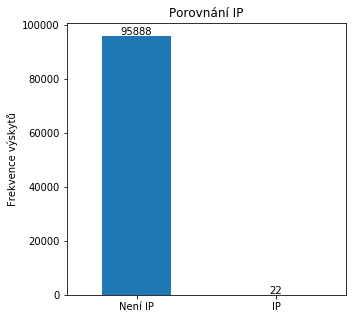

In [8]:
plot10 = df.isIp.value_counts().plot(kind='bar', figsize=(5,5),)
plot10.set_title('Porovnání IP')
plot10.set_ylabel('Frekvence výskytů')
plot10.set_xticklabels(('Není IP', 'IP'),rotation = 0 , rotation_mode="anchor")
def add_value_labels(plot10, spacing=5):
    for rect in plot10.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -5
            va = 'top'
        label = "{:.0f}".format(y_value)
        plot10.annotate(label,(x_value, y_value), xytext=(0, -1),textcoords="offset points", ha='center',va=va)                      
add_value_labels(plot10)

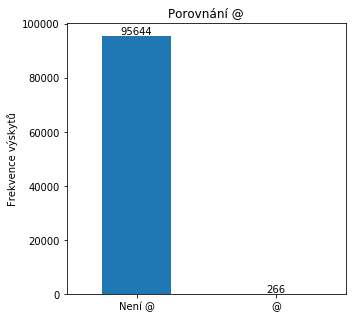

In [10]:
plot11 = df["is@"].value_counts().plot(kind='bar', figsize=(5,5),)
plot11.set_title('Porovnání @')
plot11.set_ylabel('Frekvence výskytů')
plot11.set_xticklabels(('Není @', '@'),rotation = 0 , rotation_mode="anchor")
def add_value_labels(plot11, spacing=5):
    for rect in plot11.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -5
            va = 'top'
        label = "{:.0f}".format(y_value)
        plot11.annotate(label,(x_value, y_value), xytext=(0, -1),textcoords="offset points", ha='center',va=va)                      
add_value_labels(plot11)

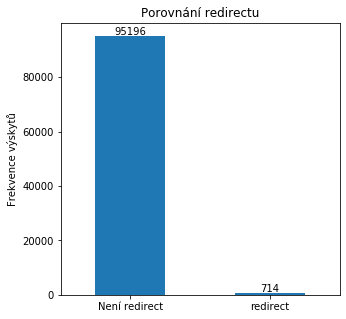

In [11]:
plot12 = df.isredirect.value_counts().plot(kind='bar', figsize=(5,5),)
plot12.set_title('Porovnání redirectu')
plot12.set_ylabel('Frekvence výskytů')
plot12.set_xticklabels(('Není redirect', 'redirect'),rotation = 0 , rotation_mode="anchor")
def add_value_labels(plot12, spacing=5):
    for rect in plot12.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -5
            va = 'top'
        label = "{:.0f}".format(y_value)
        plot12.annotate(label,(x_value, y_value), xytext=(0, -1),textcoords="offset points", ha='center',va=va)                      
add_value_labels(plot12)

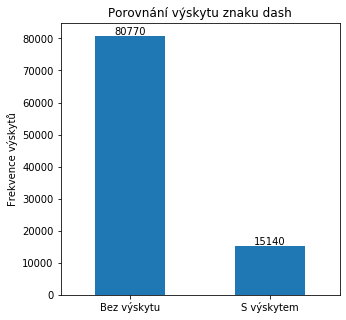

In [12]:
plot13 = df.haveDash.value_counts().plot(kind='bar', figsize=(5,5),)
plot13.set_title('Porovnání výskytu znaku dash')
plot13.set_ylabel('Frekvence výskytů')
plot13.set_xticklabels(('Bez výskytu', 'S výskytem'),rotation = 0 , rotation_mode="anchor")
def add_value_labels(plot13, spacing=5):
    for rect in plot13.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -5
            va = 'top'
        label = "{:.0f}".format(y_value)
        plot13.annotate(label,(x_value, y_value), xytext=(0, -1),textcoords="offset points", ha='center',va=va)                      
add_value_labels(plot13)

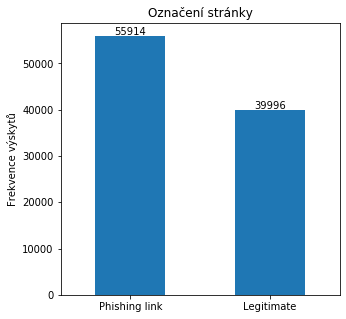

In [13]:
plot14 = df.label.value_counts().plot(kind='bar', figsize=(5,5),)
plot14.set_title('Označení stránky')
plot14.set_ylabel('Frekvence výskytů')
plot14.set_xticklabels(('Phishing link', 'Legitimate'),rotation = 0 , rotation_mode="anchor")
def add_value_labels(plot14, spacing=5):
    for rect in plot14.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -5
            va = 'top'
        label = "{:.0f}".format(y_value)
        plot14.annotate(label,(x_value, y_value), xytext=(0, -1),textcoords="offset points", ha='center',va=va)                      
add_value_labels(plot14)

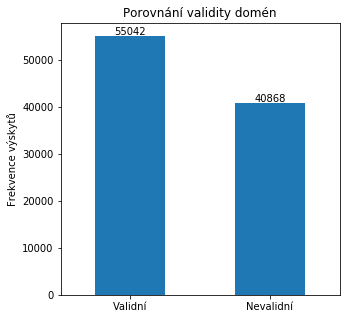

In [14]:
plot1 = df.valid.value_counts().plot(kind='bar', figsize=(5,5),)
plot1.set_title('Porovnání validity domén')
plot1.set_ylabel('Frekvence výskytů')
plot1.set_xticklabels(('Validní', 'Nevalidní'),rotation = 0 , rotation_mode="anchor")
def add_value_labels(plot1, spacing=5):
    for rect in plot1.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -5
            va = 'top'
        label = "{:.0f}".format(y_value)
        plot1.annotate(label,(x_value, y_value), xytext=(0, -1),textcoords="offset points", ha='center',va=va)                      
add_value_labels(plot1)

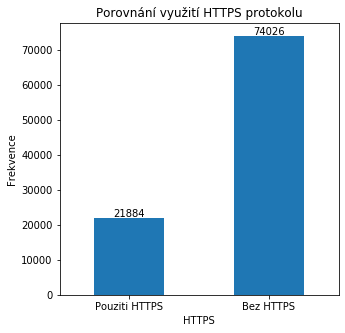

In [15]:
value_order = [1,0]
plot2 = df.usesHttps.value_counts().loc[value_order].plot(kind='bar', figsize=(5,5))
plot2.set_title('Porovnání využití HTTPS protokolu')
plot2.set_ylabel('Frekvence')
plot2.set_xlabel('HTTPS')
plot2.set_xticklabels(('Pouziti HTTPS', 'Bez HTTPS'),rotation = 0 , rotation_mode="anchor")
def add_value_labels(plot2, spacing=5):
    for rect in plot2.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -5
            va = 'top'
        label = "{:.0f}".format(y_value)
        plot2.annotate(label,(x_value, y_value), xytext=(0, -1),textcoords="offset points", ha='center',va=va)                      
add_value_labels(plot2)

Vizualizace rozdělení durace pomocí histogramu na ekvidistantní intervaly nám ukazuje, že významná část záznamů je v prvním koši. Zároveň se objevují outlier values ve vyšších tisících durace.

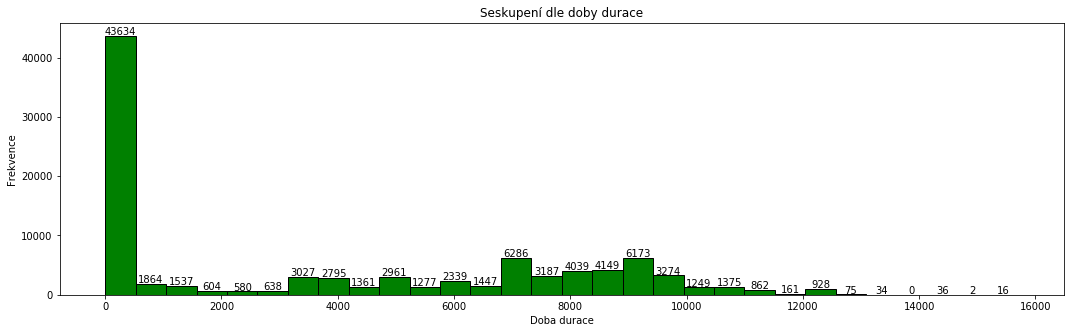

In [16]:
plot3 = df.activeDuration.plot(kind='hist', bins = 30, figsize=(18,5), facecolor = 'green', edgecolor='black')
plot3.set_title('Seskupení dle doby durace')
plot3.set_ylabel('Frekvence')
plot3.set_xlabel('Doba durace')
def add_value_labels(plot3, spacing=5):
    for rect in plot3.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -5
            va = 'top'
        label = "{:.0f}".format(y_value)
        plot3.annotate(label,(x_value, y_value), xytext=(0, -1),textcoords="offset points", ha='center',va=va)
add_value_labels(plot3)

Očištěním o hodnoty 0 (které tvořily převážnou část prvního koše) a hodnoty nad 10000, získáme lepší přehled o rozložení durace mezi jednotlivé záznamy.

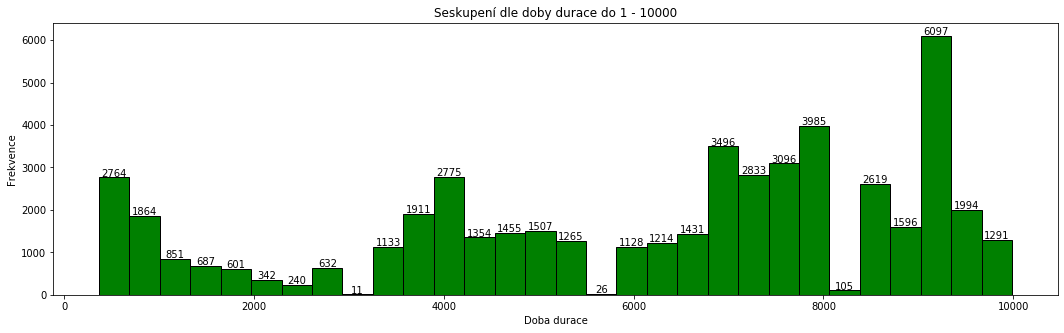

In [17]:
values0 = df.activeDuration
values0 = values0[values0.between(1,10000)]

plot4 = values0.plot(kind='hist', bins = 30, figsize=(18,5), facecolor = 'green', edgecolor='black' )
plot4.set_title('Seskupení dle doby durace do 1 - 10000')
plot4.set_ylabel('Frekvence')
plot4.set_xlabel('Doba durace')

def add_value_labels(plot4, spacing=5):
    for rect in plot4.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -1
            va = 'top'
        label = "{:.0f}".format(y_value)
        plot4.annotate(label,(x_value, y_value), xytext=(0, -1),textcoords="offset points", ha='center',va=va)
add_value_labels(plot4)

Následující histogram seskupuje záznamy dle délky URL adresy. Zde vidíme zase významný první koš stejně jako outliery, kteří ubírají na vypovídací hodnotě celému histogramu.

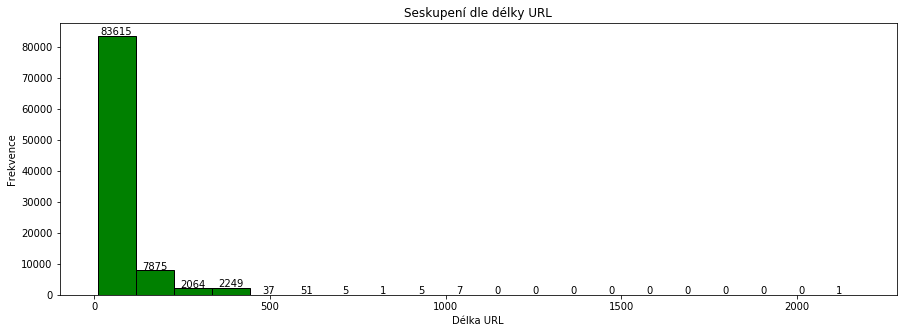

In [18]:
plot5 = df.urlLen.plot(kind='hist', bins = 20, figsize=(15,5), facecolor = 'green', edgecolor='black')
plot5.set_title('Seskupení dle délky URL')
plot5.set_ylabel('Frekvence')
plot5.set_xlabel('Délka URL')
def add_value_labels(plot5, spacing=5):
    for rect in plot5.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -5
            va = 'top'
        label = "{:.0f}".format(y_value)
        plot5.annotate(label,(x_value, y_value), xytext=(0, -1),textcoords="offset points", ha='center',va=va)
add_value_labels(plot5)

### < Poznamky oponenta >
- zde je vhodne zvolit jiny typ grafu, treba boxplot, ktery prehledne zobrazi outliers.

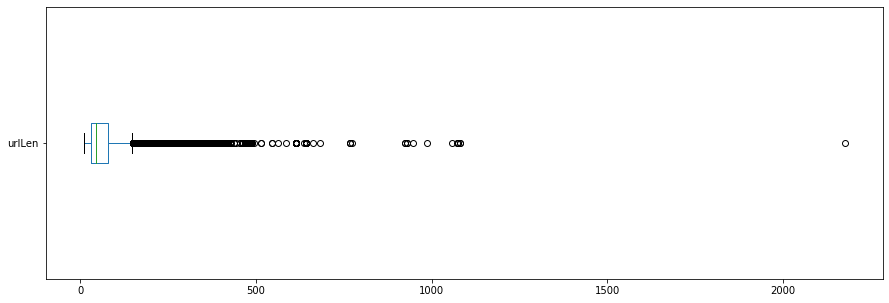

In [26]:
# KOD OPONENTA
plot5 = df.urlLen.plot(kind='box', vert=False,figsize=(15,5))

Pokud se zaměříme pouze na první část předchozího histagramu (hodnoty 0 - 200), získáme mnohem lepší přehled o rozložení délky URL v našem datasetu.

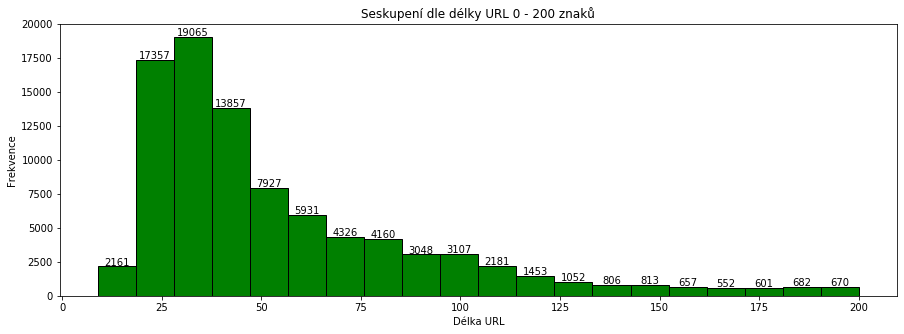

In [27]:
values1 = df.urlLen
values1 = values1[values1.between(0,200)]

plot6 = values1.plot(kind='hist', bins = 20, figsize=(15,5), facecolor = 'green', edgecolor='black')
plot6.set_title('Seskupení dle délky URL 0 - 200 znaků')
plot6.set_ylabel('Frekvence')
plot6.set_xlabel('Délka URL')
def add_value_labels(plot6, spacing=5):
    for rect in plot6.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -5
            va = 'top'
        label = "{:.0f}".format(y_value)
        plot6.annotate(label,(x_value, y_value), xytext=(0, -1),textcoords="offset points", ha='center',va=va)
add_value_labels(plot6)

Zajímavý je vztah délky domény a URL, který vyjadřuje následující graf. Tento graf opět zkresluje významný outlier, proto v dalším kroku omezím hodnotu pouze na délku URL do 500 znaků.

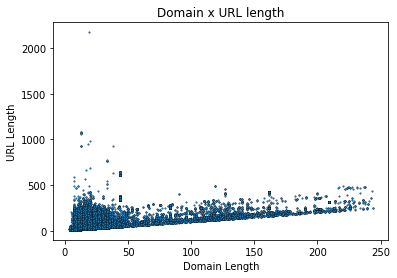

In [28]:
plt.scatter(df.domainLen, df.urlLen, s = 3, edgecolor='black', linewidth=0.2)
plt.xlabel('Domain Length')
plt.ylabel('URL Length')
plt.title('Domain x URL length')
plt.show()

Odstranění outlieru s hodnotou délky URL nad 500 znaků. Nyní vidíme přesněji jak se chová vztah délky URL a domény.

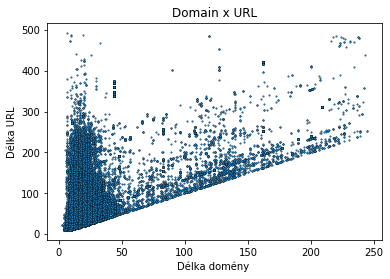

In [30]:
df.drop(df.index[df['urlLen'] > 500], inplace = True)
plt.scatter(df.domainLen, df.urlLen, s = 3, edgecolor='black', linewidth=0.2)
plt.xlabel('Délka domény ')
plt.ylabel('Délka URL')
plt.title('Domain x URL')
plt.show()

Pro lepší přehled, jak se liší délka domény a URL je vhodnější zobrazit pouze rozdíl těchto dvou délek. Porovnání rozdílu mezi délkou domény a délkou URL a následné vyrovnání dle výše rozdílu. Zároveň stále nebereme v potaz vyčnívající hodnoty.

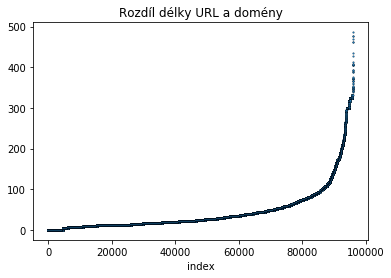

In [31]:
df.drop(df.index[df['urlLen'] > 1200], inplace = True)
len_diff = df.urlLen-df.domainLen
plt.scatter(len_diff.index, np.sort(len_diff), s = 3, edgecolor='black', linewidth=0.2)
plt.xlabel('index')
plt.title('Rozdíl délky URL a domény')
plt.show()

Validita a durace má přímý vztah, jak je vidět z grafu, pro hodnotu validity 0 je hodnota durace vždy 0. Pro hodnoty validity 1 je hodnota durace větší než 0.

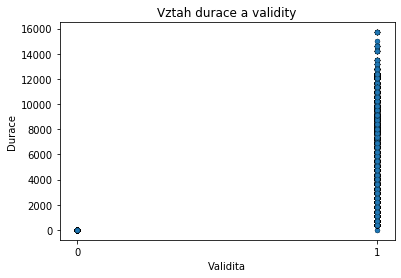

In [32]:
plt.scatter(df.valid, df.activeDuration, s = 25, edgecolor='black', linewidth=0.2)
plt.xlabel('Validita')
plt.ylabel('Durace')
plt.title('Vztah durace a validity')
plt.xticks(np.arange(0, 2, 1.0))
plt.show()

Následující graf ukazuje kolik mají domény subdomén a frekvenci výskytů jednotlivých variant v našem datasetu.

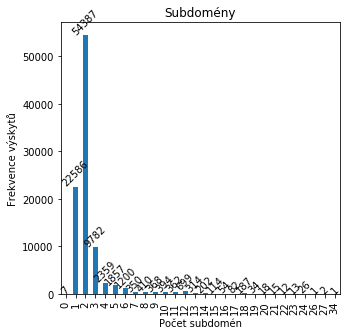

In [33]:
plot7 = df.nosOfSubdomain.value_counts().sort_index().plot(kind='bar', figsize=(5,5),)
plot7.set_title('Subdomény')
plot7.set_ylabel('Frekvence výskytů')
plot7.set_xlabel('Počet subdomén')

def add_value_labels(plot7, spacing=5):
    for rect in plot7.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -5
            va = 'top'
        label = "{:.0f}".format(y_value)
        plot7.annotate(label,(x_value, y_value), xytext=(0, -1),textcoords="offset points", ha='center',va=va, rotation = 45)                      
add_value_labels(plot7)

# Předzpracování dat

Třída **WebsitesContainer** zapouzdřuje data webových stránek. Umožňuje, aby jednotlivé vytvářené modely pracovaly s různě velkými a různě předzpracovanými daty. Předzpracování dat probíhá v konstruktoru této třídy. Předzpracování spočívá v:

**odvození nových sloupců**

Z původního datasetu budou ze sloupce *domain* odvozeny tyto sloupce:

|Název sloupce|Popis|
|:---|:---|
|**isTinyUrl**|zda je použita tiny url|
|**topLevelDomain**|samotná top level doména|
|**nonStandardPort**|nestandardnost portu|
|**containsUnderline**|dděleni slov v doméně symbolem '_'|
|**containsPort**|uvedení portu v adrese |
|**containsWWW**|výskyt 'www' subdomény|
|**containsPaypal**|výskyt slova *paypal* v adrese|
|**containsBank**|výskyt slova *bank* v adrese|
|**containsSecure**|výskyt slova *secure* v adrese|
|**paramsCount**|počet query parametrů|
|**usesHttps**|zda je možné navázat spojení přes HTTPS|

Odvození sloupců závisí na parametru *derive* v konstruktoru. Výchozí hodnota je **True**.

**použítí externích metrik**

Zajímavé by bylo zjistit, jak si modely vedou, pokud mohou vycházet pouze se samostatnou hodnotou url adresy a nespoléhat na metriky třetích stran. Použíti externích metrik, tedy sloupců *ranking*, *activeDuration* a *valid* závisí v konstruktoru na paramteru *use_metrics*. Výchozí hodnota je **True**.

**naškálování dat**

Obory hodnot se napříč slopci velmi liší. Proto může pro vytvoření lepšího modelu pomoct hodnoty ve sloupcích naškálovat. Hodnoty ve všech sloupcích dosahují pouze kladných hodnot. Pro škálování byla použita třída MaxAbsScaler z balíčku **sklearn.preprocessing**. Škálování je volitelné, použití je ovlivňuje parametrem *scale*, výchozí hodnota je **True**.

**odstranění *outlierů***

Ve sloupcí *urlLen*, *activeDuration* a odvozeném sloupci *paramsCount* se vyskytují hodnoty, které se značně  oddalují mediánu těchto sloupců. Může pomoct tyto záznamy odstranit.

**vytvořění *dummy variables* pro nominální sloupce**

Jediný sloupec s nominálními hodnotami, který bude použit pro tvorbu modelu je sloupec *topLevelDomain*. Pro ten budou vytvořeny dummy sloupce s pomocí knihovny pandas a funkcí *get_dummies*.

Pro tvorbu modelu samozřejmě nebude použit sloupec *domain*. Modely s tímto sloupcem by byly pokaždé přeučené. V konstruktoru je možné určit velikost dat použitých z původního datasetu parametrem *n*. Ten je volitelný, při neuvedení tohoto parametru jsou použita všechna data. 

Podle *n* se vyřízne polovina z *n* validních stránek a polovina podvodných stránek. V původním datasetu je podvodných stránek víc, takže při větších *n* proběhne *oversampling* technikou **SMOTE**.

Dostupné metody třídy jsou:
* **get_data** -> vrací celý soubor předzpracovaných dat: tuple vysvětlujících proměnných a cílové proměnné
* **split_data** -> rozloží data na trénovací a testovací podle zadané *test_size*
* **get_feature_names** -> pro vizualizaci například rozhodovacím stromem vrací názvy použitých sloupců

K tomu je dostupný statický atribut **class_names** s labely cílových proměnných.

In [ ]:
class WebsitesContainer:
    
    class_names = ['ok', 'malicious']
    
    def __init__(self, n = 0,use_metrics=True, scale=True,derive=True,remove_outliers=True):
        self.__df = df.copy()
        if derive:
            self.__derive_all()
        if remove_outliers:
            self.__remove_outliers()
        if n == 0:
            n = self.__df.shape[0]  
        ok = self.__df[self.__df['label'] == 0].iloc[:int(n/2)]
        malicious = self.__df[self.__df['label'] == 1].iloc[:int(n/2)]
        self.__df = pd.concat([ok,malicious])
        if not use_metrics:
            self.__df = self.__df.drop(['ranking', 'activeDuration', 'valid'], axis='columns')
        self.__df = self.__df.drop(['domain'], axis='columns')
        self.__df = pd.get_dummies(self.__df, drop_first=True)
        self.__df_X = self.__df.drop(['label'], axis='columns')
        self.X = self.__df_X.values
        self.__df_y = self.__df['label']
        self.y = self.__df_y.values
        if scale:
            scaler = MaxAbsScaler()
            self.X = scaler.fit_transform(self.X)
        if ok.shape[0] != malicious.shape[0]:
            smote = SMOTE(random_state=0,n_jobs=-1)
            self.X, self.y = smote.fit_sample(self.X, self.y)
        self.feature_names = self.__df_X.columns.values
            
        
    def get_data(self):
        return (self.X, self.y)
        
    def split_data(self, test_size = 0.3):
        return train_test_split(self.X,self.y,test_size=test_size, stratify=self.y, random_state=0)
    
    def get_feature_names(self):
        return self.__df_X.columns.values
    
    def __remove_outliers(self):
        urlLen_high = self.__df["urlLen"].quantile(0.97)
        domainLen_high = self.__df["domainLen"].quantile(0.95)
        paramsCount_high = self.__df["paramsCount"].quantile(0.998)
        self.__df = self.__df[(self.__df["domainLen"] < domainLen_high)]
        self.__df = self.__df[(self.__df["urlLen"] < urlLen_high)]
        self.__df = self.__df[(self.__df["paramsCount"] < paramsCount_high)]
    
    def __derive_all(self):
        self.__apply('domain','isTinyUrl',self.__is_tiny_url)
        self.__apply('domain','topLevelDomain',self.__top_level_domain)
        self.__apply('domain','nonStandardPort',self.__non_standard_port)
        self.__apply('domain','containsUnderline',self.__matches_regex,["\w+_\w+"])
        self.__apply('domain','containsPort',self.__matches_regex,[":\d+"])
        self.__apply('domain','containsWWW',self.__matches_regex,["www\."])
        self.__apply('domain','containsPaypal',self.__matches_regex,["paypal"])
        self.__apply('domain','containsBank',self.__matches_regex,["bank"])
        self.__apply('domain','containsSecure',self.__matches_regex,["secure"])
        self.__apply('domain','paramsCount',self.__query_params_count)        
    
    def __apply(self,column_name,new_column_name,function,args = []):
        self.__df[new_column_name] = self.__df[column_name].apply(function, args=args)
    
    def __matches_regex(self,string, regex):
        return int(len(re.findall(pattern=regex,string=string)) > 0)

    def __find_first(self,string, regex):
        arr = re.findall(pattern=regex,string=string)
        if len(arr) > 0:
            return arr[0]

    def __top_level_domain(self,domain):
        return self.__find_first(domain,"(?<=\.)\w+(?=\?|$|/)")

    def __non_standard_port(self,domain):
        port_string = self.__find_first(domain,"(?<=\:)\d+")
        if port_string is not None:
            port = int(self.__find_first(domain,"(?<=\:)\d+"))
            return int(not (port == 443 or port == 80))
        else:
            return 0  

    def __is_tiny_url(self,domain):
        for tinyurl in tinyurls['domain']:
            if self.__matches_regex(domain,tinyurl):
                return 1
        return 0    

    def __query_params_count(self,domain):
        return len(re.findall(pattern='(?<=&|\?)\w+(?=\=)',string=domain))

    def __uses_https(self,domain):
        url = 'https://' + domain
        try:
            r = requests.get(url,timeout=5)
            r.raise_for_status()
        except requests.exceptions.RequestException as err:
            return 0
        return 1

# Tvorba modelů

Pro klasifikaci webových stránek budou použity tyto algoritmy:

**s vysvětlitelným modelem**

* Logistická regrese
* Rozhodovací strom

**s nevysvětlitelným modelem**

* Multilayer Perceptron
* Random forests

Použití každého algoritmu bude sestávat z těchto kroků

1. vytvoření instance předzpracovaných dat a jejich rozdělení na trénovací a testovací
2. vytvoření modelu s výchozími hyperparametry
3. evaluace modelu (s interpretací pro vysvětlitelné modely)
4. hledání optimálních hyperparametrů s křížovou validací (s použitím GridSearchCV dochází k přetrénování nalezeného modelu nad celými trénovacími daty)
6. evaluace přetrénovaného modelu

## Pomocné funkce

Pomocné funkce jsou v dalších buňkách použity pro vizualizaci a evaluaci vytvořených modelů.

**evaluate**

Tato funkce vykreslí pro zadaný estimator a validační data křivku ROC a matici záměn. Tyto dva grafy jsme zvolili, jednak protože se jedná o binární klasifikační úlohu a matice zájem není příliš rozměrná na to, aby se dala jednoduše číst a jednak protože ROC křivku si vynucují [požadavky](http://4iz565.gitlab.io/requirements/) na práci. Nad ROC křivkou je vždy uvedena i plocha pod křivkou (AUC).

**feature_importances**

Funkce zobrazí porovnání důležitostí použitých proměnných pro model rozhodovacího stromu. Pro lepší čitelnost jsou zobrazeny pouze vlastnosti, které přesáhnou minimální mez *0.001*. Hodnoty jsou zobrazeny jako horizontální sloupcový graf.

**logistic_coefs**

Funkce zobrazí rozsah koeficientů proměnných zadaného modelu logistické regrese a je možné vyčíst, jaká proměnná má jak velký (a v jakém směru) vliv na šanci pro klasifikaci url adresy jako podvodné.

**visualise_tree**

Funkce visualisuje model rozhodovacího stromu jako binární strom. Uzly s odlišnými převažujícími cílovými proměnnými jsou barevně odlišeny (podvodné jako modré, bezpečné jako oranžové uzly)

**show_params**

Pro GridSearchCV a LogisticRegressionCV objekty vytiskne vybrané nejlepší hyperparametry modelu.

**compare_estimators**

Slouží pro porovnání vytvořených modelů.

In [ ]:
def evaluate(estimator, X_test, y_test):
    y_pred_proba = estimator.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    line  = [0,1]
    auc_score = auc(fpr, tpr)
    fig,a =  plt.subplots(1,2, figsize=(14,7))
    a[0].plot(fpr, tpr, color='blue',label="ROC")
    a[0].plot(line, color='green', label="náhodný výběr", linestyle='dashed', marker='o')
    a[0].legend(loc='lower right')
    a[0].set_title("ROC Křivka (AUC = %0.4f)" % auc_score)
    a[0].set_xlabel("1 - P")
    a[0].set_ylabel("R")
    plot_confusion_matrix(estimator,
                          X_test,
                          y_test,
                          cmap='Blues',
                          display_labels=['ok', 'mal'],
                          values_format=".0f",ax=a[1])
    accuracy = estimator.score(X_test, y_test)
    a[1].set_title("Matice záměn (Přesnost: {})".format(round(accuracy,4))) # (přesnost= #)
    a[1].set_xlabel("Predikovaná hodnota")
    a[1].set_ylabel("Skutečná hodnota")
    plt.show()

def compare_estimators(estimators):
    fig,a =  plt.subplots(1,2, figsize=(14,7))
    line  = [0,1]
    a[0].plot(line, color='green', label="náhodný výběr", linestyle='dashed', marker='o')
    a[0].set_title("ROC Křivky")
    a[0].set_xlabel("1 - P")
    a[0].set_ylabel("R")
    table_data = []
    for estimator in estimators:
        model = estimator[0]
        X_test = estimator[1]
        y_test = estimator[2]
        name = model.__class__.__name__
        accuracy = model.score(X_test, y_test)
        table_data.append([name, "{}".format(round(accuracy,3))])
        y_pred = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        auc_score = auc(fpr, tpr)
        a[0].plot(fpr, tpr,label=name+" (AUC = %0.4f)" % auc_score)
    a[0].legend(loc='lower right')
    table_data.sort(key = lambda x : x[1], reverse = True)
    a[1].table(cellText=table_data, loc='center')
    a[1].axis('off')
    a[1].set_title("Přesnost modelů")
    plt.show()

def feature_importances(tree, container):
    feature_names = []
    importances = []
    all_feature_names = container.get_feature_names()
    all_importances = tree.feature_importances_
    for k, v in enumerate(all_importances):
        if v > 0.001:
            feature_names.append(all_feature_names[k])
            importances.append(all_importances[k])
            
    plt.figure(figsize=(10,7))
    plt.barh(range(len(feature_names)), importances, align='center')
    plt.yticks(np.arange(len(feature_names)), feature_names)
    plt.xlabel("Důležitost sloupce")
    plt.ylabel("Sloupce")
    plt.show()
    
def logistic_coefs(logreg, container):
    feature_names = []
    coefs = []
    all_feature_names = container.get_feature_names()
    all_coefs = logreg.coef_.T
    for k, v in enumerate(all_coefs):
        if abs(v) > 0.2:
            feature_names.append(all_feature_names[k])
            coefs.append(all_coefs[k])
    
    n_features = len(feature_names)
    plt.figure(figsize=(16,7))
    plt.plot(coefs, 'o')
    plt.xticks(range(n_features), feature_names, rotation=90)
    plt.hlines(0, 0, n_features)
    limit =  max(abs(logreg.coef_.T)) + 1
    plt.ylim(-limit, limit)
    plt.xlabel("Proměnná")
    plt.ylabel("Koeficient")
    plt.show()
    
def visualise_tree(tree, container):
    feature_names = container.get_feature_names()
    plt.figure(figsize=(10, 3), dpi=500, facecolor='w', edgecolor='k')
    plot_tree(tree,
              feature_names=feature_names,
              class_names=WebsitesContainer.class_names,
              proportion=True, 
              filled=True)
    plt.show()
    
def show_params(estimator):
    print("Parametry:\n")
    if hasattr(estimator, 'best_params_'):
        for i in estimator.best_params_.items():
            print("{}:\t{}".format(i[0],i[1]))
    elif hasattr(estimator, 'C_'):
        print("C:\t{}".format(estimator.C_[0]))

## Logistická regrese


In [ ]:
logreg_container = WebsitesContainer()
logreg_X_train, logreg_X_test, logreg_y_train, logreg_y_test = logreg_container.split_data(test_size=0.3)

In [ ]:
%%capture
logreg = LogisticRegression()
logreg.fit(logreg_X_train, logreg_y_train)

### Evaluace


In [ ]:
evaluate(logreg,logreg_X_test,logreg_y_test)

### Koeficienty proměnných

Nejvíc zvyšuje šanci na klasifikaci url adresy jako podvodné její délka ve znacích. Naopak vyšší doba, po kterou je url adresa aktivní zvyšuje kredibilitu adresy a top level doména *edu*.

In [ ]:
logistic_coefs(logreg, logreg_container)

### LogisticRegressionCV

Použita byla třída LogisticRegressionCV. Ta prohledává pouze vzhledem k hyperparametru C.

In [ ]:
%%capture
logreg_cv = LogisticRegressionCV(cv=10, Cs=20, max_iter=1000, n_jobs=-1)
logreg_cv.fit(logreg_X_train, logreg_y_train)

#### Evaluace
Nalezený model má větší míru AUC než předešlý model.

In [ ]:
evaluate(logreg_cv,logreg_X_test,logreg_y_test)
show_params(logreg_cv)

#### Koeficienty proměnných

Koeficienty jsou oproti předešlému model méně regulovány.

In [ ]:
logistic_coefs(logreg_cv, logreg_container)

## Rozhodovací strom

In [ ]:
tree_container = WebsitesContainer()
tree_X_train, tree_X_test, tree_y_train, tree_y_test = tree_container.split_data(test_size=0.3)

In [ ]:
%%capture
tree = DecisionTreeClassifier(random_state=0)
tree.fit(tree_X_train, tree_y_train)

### Evaluace

In [ ]:
evaluate(tree,tree_X_test,tree_y_test)

### Použité proměnné

Na rozdíl od modelu logistické regrese se model významně opírá o proměnnou ranking.

In [ ]:
feature_importances(tree, tree_container)

### Vizualizace stromu
Strom už je příliš hluboký na to, aby se v tomto notebooku dal pohodlně číst.

In [ ]:
visualise_tree(tree, tree_container)

### Menší strom

Zajímavé bude vytvořit mělký strom například o hloubce 3.

In [ ]:
%%capture
tree = DecisionTreeClassifier(max_depth=3,random_state=0)
tree.fit(tree_X_train,tree_y_train)

Při konstrukci stromu je použit i odvozený atribut *usesHttps*.

In [ ]:
visualise_tree(tree, tree_container)

#### Evaluace
Míra AUC neukazuje úplně špatný výsledek na tak jednoduchý strom.

In [ ]:
evaluate(tree,tree_X_test,tree_y_test)

In [ ]:
feature_importances(tree, tree_container)

### Grid Search

Optimální rozhodovací strom budeme vyhledávat v prostoru použitého kritéria (*gini* nebo entropie) a maximální hloubky stromu. Hlubší strom znamená složitější, mělčí strom jednodušší model.

In [ ]:
%%capture
tree = DecisionTreeClassifier(random_state=0)
parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(10, 100, 10),
}
tree_cv = GridSearchCV(tree, parameters, cv=10, n_jobs=-1)
tree_cv.fit(tree_X_train,tree_y_train)

#### Evaluace

In [ ]:
evaluate(tree_cv,tree_X_test,tree_y_test)
show_params(tree_cv)

In [ ]:
feature_importances(tree_cv.best_estimator_, tree_container)

## Multilayer Perceptron

První nevysvětlitelný model je umělá neuronová síť Multilayer Perceptron. Podává trochu lepší výsledky ale její trénování trvá znatelně déle.

In [ ]:
mlp_container = WebsitesContainer(n=5000)
mlp_X_train, mlp_X_test, mlp_y_train, mlp_y_test = mlp_container.split_data(test_size=0.3)

In [ ]:
%%capture
mlp = MLPClassifier(random_state=0)
mlp.fit(mlp_X_train,mlp_y_train)

### Evaluace

In [ ]:
evaluate(mlp,mlp_X_test, mlp_y_test)

### Grid Search

Bude se vyhledávat v prostoru parametru *alpha*. Jeho výchozí hodnota je *0.001*. Vyšší hodnota znamená jednodušší model.

In [ ]:
%%capture
mlp = MLPClassifier(random_state=0, max_iter=1000)
parameters = {
    'alpha': np.logspace(-7, 4, 12),
}
mlp_cv = GridSearchCV(mlp, parameters, cv=10, n_jobs=-1)
mlp_cv.fit(mlp_X_train,mlp_y_train)

#### Evaluace

In [ ]:
evaluate(mlp_cv,mlp_X_test, mlp_y_test)
show_params(mlp_cv)

## Random Forests

In [ ]:
forest_container = WebsitesContainer()
forest_X_train, forest_X_test, forest_y_train, forest_y_test = forest_container.split_data(test_size=0.3)

In [ ]:
%%capture
forest = RandomForestClassifier(random_state=0)
forest.fit(forest_X_train, forest_y_train)

### Evaluace

In [ ]:
evaluate(forest,forest_X_test, forest_y_test)

### Grid Search

Budeme ladit tyto hyperparametry:
* **n_estimators**: počet stromů v lese. Více stromu vytváří složitější model
* **criterion**: kritérium pro porovnání kvality rozdělení souboru ve větvi

In [ ]:
%%capture
forest = RandomForestClassifier(random_state=0)
parameters = {
    'n_estimators': np.logspace(1,3,3, dtype='int64'),
    'criterion': ['gini', 'entropy'],
}
forest_cv = GridSearchCV(forest, parameters, cv=10, n_jobs=-1)
forest_cv.fit(forest_X_train, forest_y_train)

#### Evaluace

In [ ]:
evaluate(forest_cv,forest_X_test, forest_y_test)

# Porovnání modelů

Vytvořené modely budeme porovnávat:
* zanesením jejich ROC křivky do jednoho grafu
* seřazením podle dosažené přesnosti

In [ ]:
estimators = [
    [tree_cv.best_estimator_, tree_X_test, tree_y_test],
    [logreg_cv, logreg_X_test, logreg_y_test],
    [mlp_cv.best_estimator_, mlp_X_test, mlp_y_test],
    [forest_cv.best_estimator_, forest_X_test, forest_y_test],
]
compare_estimators(estimators)

# Závěr

V rámci této práce byly nad předzpracovanými daty vytvořeny modely algoritmů rozhodovacího stromu, random forrestu, multilayer perceptronu a logistické regrese. Pro multilayer perceptron byl použit zlomek dostupných dat, aby bylo možné model natrénovat v rozumném čase. Nejlépe ze srovnání modelů vychází algoritmus random forrestu s hodnotou AUC 99,7 % a přesností 97,5 %. Z interpretace modelů logistické regrese a rozhodovacího stromu vyplývá, že nejdůležitějšími prediktory závadnosti url adresy jsou hodnoty sloupců urlLen, activeDuration, ranking, domainLen a containsWWW. 

Vytvořené modely bohužel nejsou vhodné pro provoz, např. vystavení jako webová služba, protože jsme se z dokumentace zdrojových dat nedozvěděli, které služby byly použity pro získání dat sloupců ranking, activeDuration a valid. Dal by se vytvořit podobný model využívající libovolnou obdobnou službu, kterých je na internetu spousta. Nebo by se dal využít nový model nad stejnými daty, který tyto sloupce nevyužívá.